<a href="https://colab.research.google.com/github/ArtyomHov/tensorflow-zero-to-mastery/blob/master/07_milestone_project_1_food_vision_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

In [1]:
!nvidia-smi

Wed Oct 30 17:06:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070        Off |   00000000:01:00.0 Off |                  N/A |
| 47%   33C    P8              9W /  175W |     117MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-10-30 17:06:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-30 17:06:14 (28.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

If you want to get an overview of TensorFlow Datasets read the guide: https://www.tensorflow.org/datasets/overview

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in Tuple format
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.3WBK4S_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.3WBK4S_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets
To become one with our data, we want to find:
* Class names
* The shape of our data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are thay label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
Image shape: {image.shape}
Image datatype: {image.dtype}
Target class from Food101 dataset (tensor form): {label}
Class name (str form): {class_names[label.numpy()]}
""")


Image shape: (489, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101 dataset (tensor form): 90
Class name (str form): spaghetti_bolognese



In [12]:
# What does our image tensor from TFDS's look like?
image

<tf.Tensor: shape=(489, 512, 3), dtype=uint8, numpy=
array([[[ 83,  71,  45],
        [ 81,  69,  43],
        [ 80,  68,  44],
        ...,
        [186, 183, 142],
        [188, 185, 144],
        [185, 182, 141]],

       [[ 86,  74,  48],
        [ 83,  71,  45],
        [ 82,  70,  46],
        ...,
        [180, 177, 136],
        [179, 176, 135],
        [182, 179, 138]],

       [[ 88,  76,  52],
        [ 87,  75,  51],
        [ 85,  73,  49],
        ...,
        [188, 185, 144],
        [186, 183, 142],
        [187, 184, 143]],

       ...,

       [[162, 163, 168],
        [164, 165, 170],
        [171, 170, 176],
        ...,
        [ 75,  74,  56],
        [ 67,  66,  48],
        [ 64,  63,  45]],

       [[168, 169, 174],
        [175, 176, 181],
        [167, 166, 172],
        ...,
        [ 79,  78,  60],
        [ 74,  73,  55],
        [ 79,  78,  60]],

       [[182, 183, 188],
        [178, 179, 184],
        [163, 164, 169],
        ...,
        [ 75,  74,  5

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow dataset

(-0.5, 511.5, 488.5, -0.5)

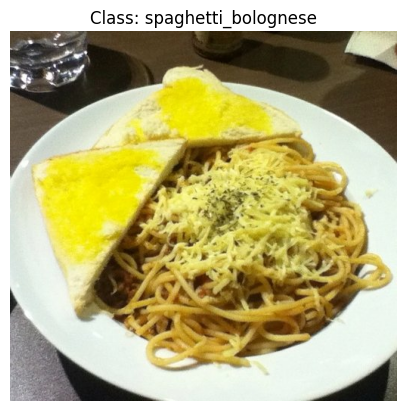

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"Class: {class_names[label.numpy()]}") # Add title to image to verify the label is assosiated with the right image
plt.axis(False)

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from Tensorflow Datasets) comes like this,

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)


What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions need to.
1. Reshape our images to all the same size.
2. Convert the dtype of our image tensors from uint8 to float32

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32'
  Resizes the image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # normalize values to 0-1 range Not required for EfficientNetBX models
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image=image, label=label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 83  71  45]
  [ 81  69  43]
  [ 80  68  44]
  ...
  [186 183 142]
  [188 185 144]
  [185 182 141]]

 [[ 86  74  48]
  [ 83  71  45]
  [ 82  70  46]
  ...
  [180 177 136]
  [179 176 135]
  [182 179 138]]]..., 
Shape: (489, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 83.108574  71.108574  45.108578]
  [ 82.11161   70.11161   46.11161 ]
  [ 84.873245  72.873245  49.30182 ]
  ...
  [191.5464   188.5464   147.5464  ]
  [184.01991  181.01991  140.01991 ]
  [182.87247  179.87247  138.87247 ]]

 [[ 87.08051   75.08051   51.080517]
  [ 84.33609   72.33609   48.336098]
  [ 83.439735  70.796875  47.439735]
  ...
  [198.13402  195.13402  154.13402 ]
  [194.08138  191.08138  150.08138 ]
  [193.38318  190.38318  149.38318 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.
For more resources on this, it's recommended to follow this guide: https://tensorflow.org/guide/data_performance

In [17]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle tarin_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We're going to craete a coule of callbacks to help us while our model trains:
* TensorBoard callback to log training results (se we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [21]:
# Create tensorboeard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelChecpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp..weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=0) # don't print whether or not model being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [25]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

## Build feature extraction model

In [29]:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBx models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode so weights aren't updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [31]:
# Check the dtype policy attributes of layers
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going through the above we see:
* `layer.name`, the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not
* `layer.dtype`: the data type a layer stores its variables in
* `layer.data_policy`: the data type policy a layer computes on its variables with

In [33]:
# Check the dtype_policy attributes of layers in base model
for layer in base_model.layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers



In [37]:
# Fit feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                         epochs=3,
                                         steps_per_epoch=(len(train_data)),
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                  experiment_name="efficientnetb0_feature_extract"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extract/20241030-182449
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.6729 - loss: 1.2606 - val_accuracy: 0.6954 - val_loss: 1.1446
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6920 - val_loss: 1.1408
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.6997 - loss: 1.1526 - val_accuracy: 0.6870 - val_loss: 1.1135


In [38]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6972 - loss: 1.1195


[1.1127829551696777, 0.6967920660972595]